In [1]:
from __future__ import print_function, division
import sys
import os
import pandas as pd
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Data Downloads

In [2]:
PUIdata = os.getenv('PUIDATA')
print(PUIdata)

/home/cusp/uc288/PUIdata


### Data: Manhattan PLUTO information
Source: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

Download link: https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip

*This download is a zip file of the PLUTO dataset for all NYC boroughs, but for this homework, I will only use the Manhattan data.*

In [3]:
# Check if the file is in $PUIDATA
# If it's not there, proceed with download

if not os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
    print('Downloading...')
    
    # curl -O (capital O) will download the file and keep the filename in the current directory
    os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip')
    
    # move the file to $PUIDATA
    os.system('mv nyc_pluto_16v2%20.zip ' + PUIdata)
    
    # unzip the file into $PUIDATA
    os.system('unzip ' + PUIdata + '/nyc_pluto_16v2%20.zip -d ' + PUIdata)
    
    # final check
    if os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


### Data: LL84 Report for 2013
Source: https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z

Download link (retrieved from API): https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD

In [4]:
url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
filename = 'LL84_2013.csv' # filename of my choice

# Check if the file is in $PUIDATA
# If it's not there, proceed with download

if not os.path.isfile(PUIdata + '/' + filename):
    print('Downloading...')
    
    # Used wget instead of curl
    # I got an SSL connect error using curl for this (strange)
    os.system('wget ' + url)
    
    # renaming file
    os.system('mv rows.csv?accessType=DOWNLOAD ' + filename)
    
    # moving renamed file
    os.system('mv ' + filename + ' ' + PUIdata)
    
    # final check
    if os.path.isfile(PUIdata + '/' + filename):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


## Data Cleaning and Munging

In [5]:
mn_bbl = pd.read_csv(PUIdata + '/BORO_zip_files_csv/MN.csv')
mn_bbl.columns

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'

In [6]:
# too many columns to drop, chose the ones to be kept instead
mn_bbl = mn_bbl[['BBL', 'UnitsRes', 'UnitsTotal', 'YearBuilt']]
mn_bbl.head()

,BBL,UnitsRes,UnitsTotal,YearBuilt
0,1.000010e+09,0,0,1900
1,1.000010e+09,0,0,1900
2,1.000010e+09,0,0,1900
3,1.000010e+09,0,0,0
4,1.000010e+09,0,0,0


In [7]:
ll84 = pd.read_csv(PUIdata + '/LL84_2013.csv')
ll84.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BI

In [8]:
# too many columns to drop, chose the ones to be kept instead
ll84_num = ll84[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)', 
                 'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'DOF Number of Buildings', 'Postcode']]
ll84_num.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,Postcode
0,1.000410e+09,NaN,918919,NaN,NaN,NaN
1,4.021460e+09,NaN,NaN,82730.0,1.0,11375.0
2,2.027620e+09,NaN,64200,NaN,NaN,NaN
3,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0
4,2.048300e+09,NaN,50000,NaN,NaN,NaN


In [9]:
# rename columns to access columns as attributes later on
ll84_num = ll84_num.rename(columns={'Site EUI(kBtu/ft2)': 'SiteEui',
                                    'DOF Property Floor Area (Buildngs and Parking)(ft2)': 'DOFArea', 
                                    'DOF Number of Buildings': 'DOFNumBldg', 
                                    'Reported Property Floor Area (Building(s)) (ft²)': 'ReportedArea'})

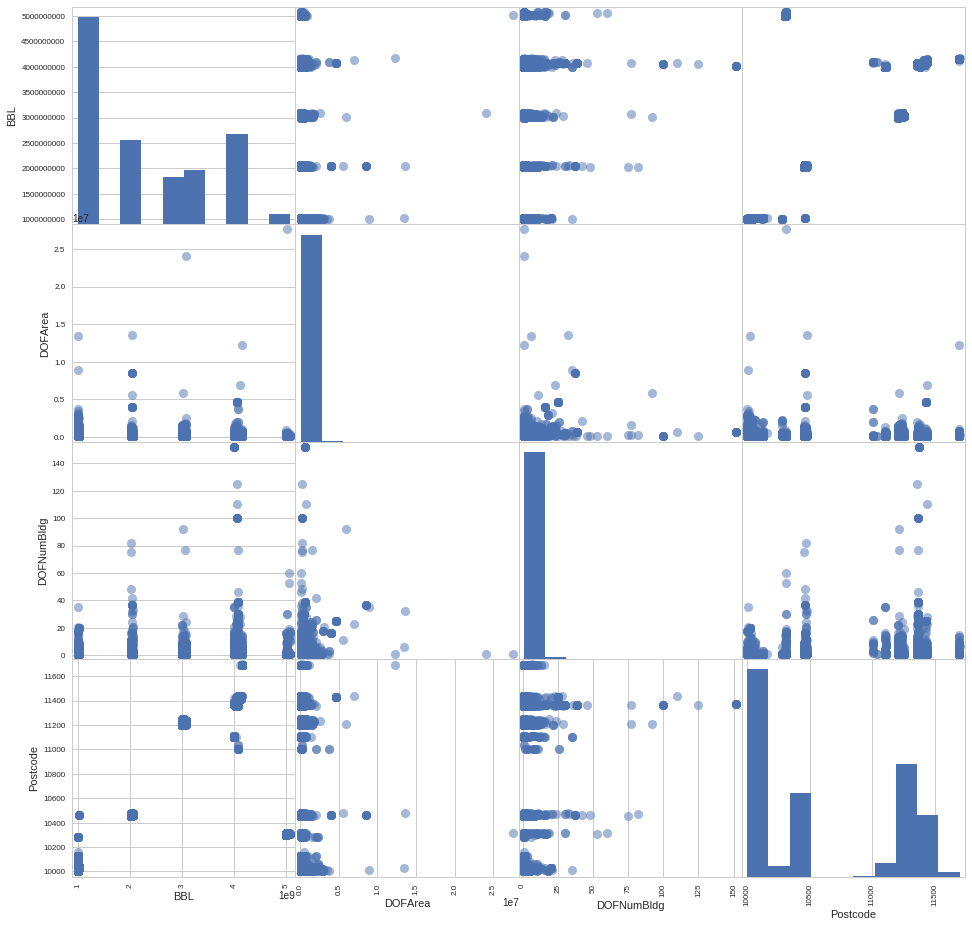

In [10]:
scatter_matrix(ll84_num, s=300, figsize=(16,16));

### Figure 1. Scatter Matrix of the LL84 Data


In [11]:
ll84_num.SiteEui = pd.to_numeric(ll84_num.SiteEui, errors='coerce')
count = np.isnan(ll84_num.SiteEui).sum()
print ("invalid entries changed to NaN %d"%sum(count))

invalid entries changed to NaN 4623


In [12]:
ll84_num.ReportedArea = pd.to_numeric(ll84_num.ReportedArea, errors='coerce')
count = np.isnan(ll84_num.ReportedArea).sum()
print ("invalid entries changed to NaN %d"%sum(count))

invalid entries changed to NaN 3125


### Merge Datasets

In [13]:
df = ll84_num.merge(mn_bbl, on='BBL')

In [14]:
df.head()

,BBL,SiteEui,ReportedArea,DOFArea,DOFNumBldg,Postcode,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,1.0,10009.0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200.0,1.0,10022.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,1.0,10003.0,148,148,1963
4,1.007400e+09,NaN,68329.0,NaN,NaN,NaN,0,1,1920


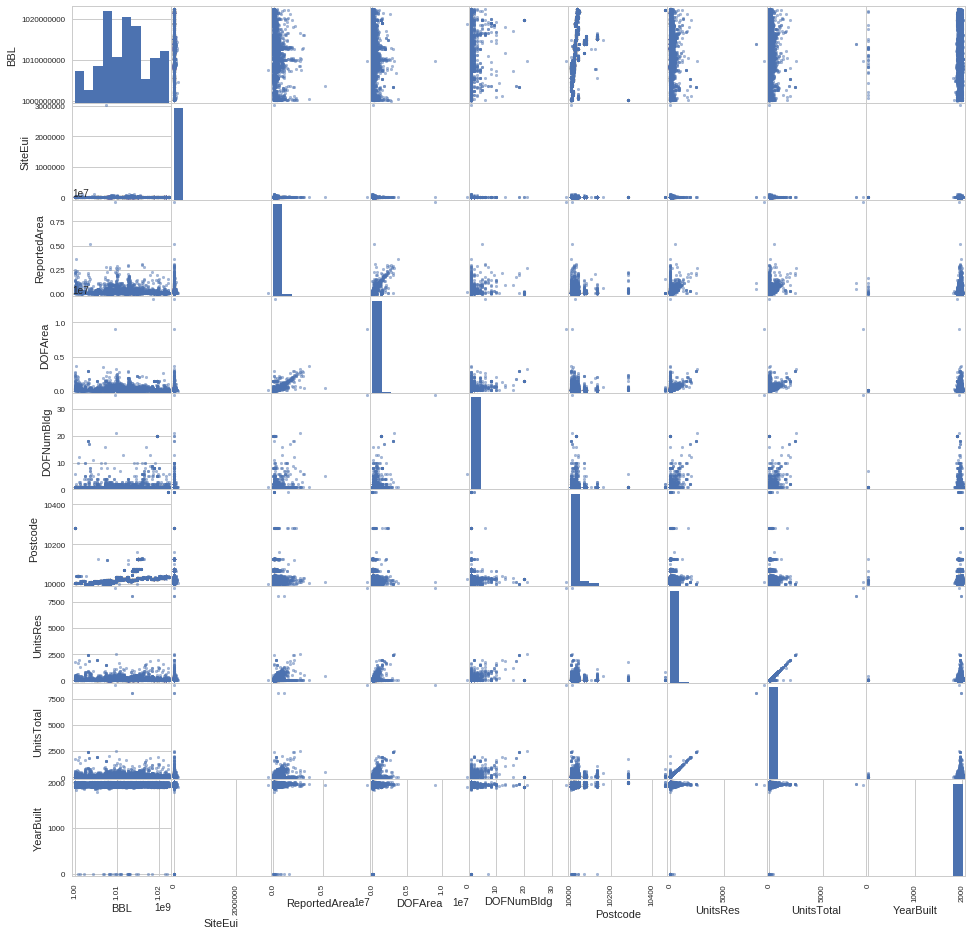

In [15]:
scatter_matrix(df, s=30, figsize=(16, 16));

### Figure 2.

In [16]:
df['EnergyCons'] = df.SiteEui * df.ReportedArea
df.head()

,BBL,SiteEui,ReportedArea,DOFArea,DOFNumBldg,Postcode,UnitsRes,UnitsTotal,YearBuilt,EnergyCons
0,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0,0,1,1987,NaN
1,1.004370e+09,NaN,NaN,52390.0,1.0,10009.0,0,4,1920,NaN
2,1.013110e+09,125.4,330000.0,313200.0,1.0,10022.0,0,56,1977,41382000.0
3,1.009220e+09,NaN,NaN,98260.0,1.0,10003.0,148,148,1963,NaN
4,1.007400e+09,NaN,68329.0,NaN,NaN,NaN,0,1,1920,NaN


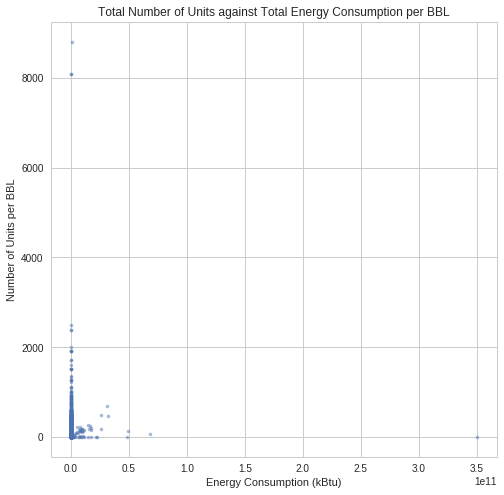

In [17]:
fig = pl.figure(figsize(8,8))
ax = fig.add_subplot(111)
ax.plot(df.EnergyCons, df.UnitsTotal, '.', alpha=0.5)
ax.set_title('Total Number of Units against Total Energy Consumption per BBL')
ax.set_xlabel('Energy Consumption (kBtu)')
ax.set_ylabel('Number of Units per BBL');

### Figure 3. Total number of units in a BBL against the Total Energy Consumption (kBtu)

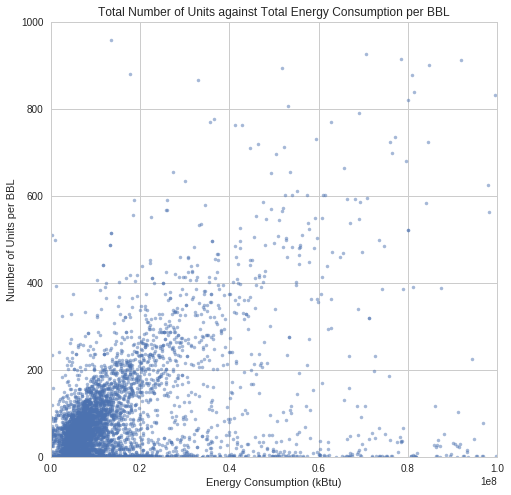

In [18]:
fig = pl.figure(figsize(8,8))
ax = fig.add_subplot(111)
ax.plot(df.EnergyCons, df.UnitsTotal, '.', alpha=0.5)
ax.set_xlim(1000,1e8)
ax.set_ylim(0,1000)
ax.set_title('Total Number of Units against Total Energy Consumption per BBL')
ax.set_xlabel('Energy Consumption (kBtu)')
ax.set_ylabel('Number of Units per BBL');

### Figure 4. Zoomed in section of Figure 3.

In [19]:
len(df)

6536

In [20]:
df.dropna(inplace=True)

In [21]:
len(df)

4705

In [22]:
df.head()

,BBL,SiteEui,ReportedArea,DOFArea,DOFNumBldg,Postcode,UnitsRes,UnitsTotal,YearBuilt,EnergyCons
2,1.013110e+09,125.4,330000.0,313200.0,1.0,10022.0,0,56,1977,41382000.0
15,1.007660e+09,122.3,59468.0,53168.0,1.0,10011.0,0,8,1912,7272936.4
16,1.008150e+09,117.0,364000.0,364000.0,1.0,10018.0,0,24,1954,42588000.0
18,1.005050e+09,82.1,235370.0,214110.0,1.0,10013.0,0,24,1926,19323877.0
19,1.021420e+09,137.7,64806.0,64816.0,1.0,10032.0,54,62,1924,8923786.2


In [23]:
df_cut = df[(df.UnitsTotal >= 10) & (df.UnitsTotal < 1000) & (df.EnergyCons > 1000)]
len(df_cut)

4008

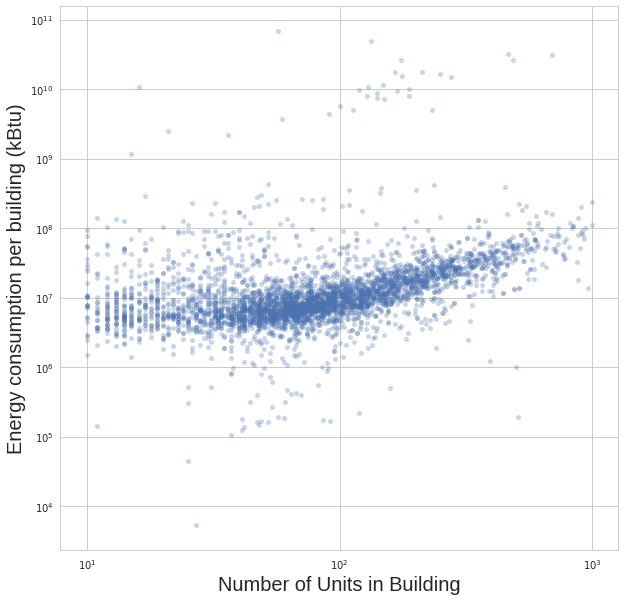

In [24]:
ax = df_cut.plot(kind='scatter', y='EnergyCons', x='UnitsTotal', 
                   marker='o',  figsize=(10, 10), loglog=True, alpha=0.3)
x1 = ax.set_xlabel("Number of Units in Building", fontsize=20)
y1 = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

### Figure 5. Scatter Plot of log(Total Energy Consumption) against log(Total Units in Building)

## Fit a Line

### Units vs Energy
Dependent variable (y): units

Independent variable (x): energy

In [25]:
x = df_cut.EnergyCons
y = df_cut.UnitsTotal

X = sm.add_constant(np.log10(x))
lm1 = sm.OLS(np.log10(y), X, missing="drop").fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     799.8
Date:                Fri, 20 Oct 2017   Prob (F-statistic):          1.38e-160
Time:                        15:49:28   Log-Likelihood:                -1604.1
No. Observations:                4008   AIC:                             3212.
Df Residuals:                    4006   BIC:                             3225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4815      0.084     -5.720      0.000        -0.647    -0.316
EnergyCons     0.3374      0.012     28.281      0.000         0.314     0.361
==============================================================================
Omnibus:                      149.144   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.686
Skew:                          -0.481   Prob(JB):                     1.05e-36
Kurtosis:                       3.260   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

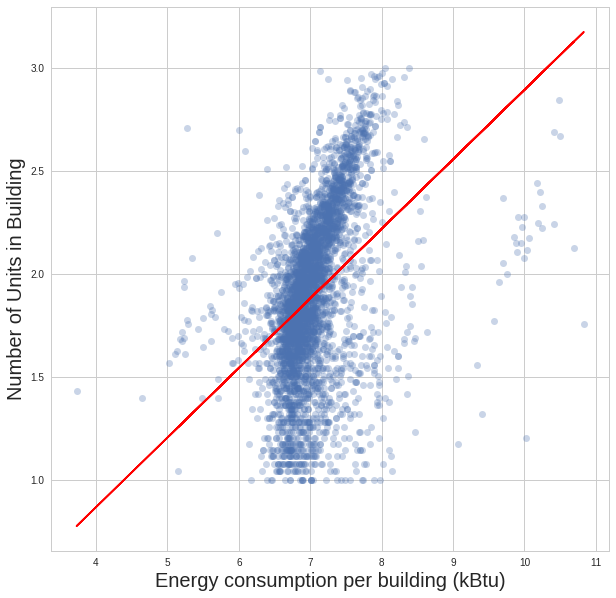

In [26]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.log10(df_cut.EnergyCons), np.log10(df_cut.UnitsTotal), 'o', alpha=0.3)
ax.plot(np.log10(df_cut.EnergyCons), lm1.predict(sm.add_constant(np.log10(df_cut.EnergyCons))), 'r-')
ax.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_ylabel("Number of Units in Building", fontsize=20);

### Figure 6. 

### Energy vs Units
Dependent variable (y): energy

Independent variable (x): units

In [27]:
# regression here
x2 = df_cut.UnitsTotal
y2 = df_cut.EnergyCons

X2 = sm.add_constant(np.log10(x2))

lm2 = sm.OLS(np.log10(y2), X2, missing='drop').fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EnergyCons   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     799.8
Date:                Fri, 20 Oct 2017   Prob (F-statistic):          1.38e-160
Time:                        15:49:28   Log-Likelihood:                -2365.2
No. Observations:                4008   AIC:                             4734.
Df Residuals:                    4006   BIC:                             4747.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1050      0.034    180.957      0.000         6.039     6.171
UnitsTotal     0.4933      0.017     28.281      0.000         0.459     0.527
==============================================================================
Omnibus:                     2200.210   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46847.024
Skew:                           2.162   Prob(JB):                         0.00
Kurtosis:                      19.181   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

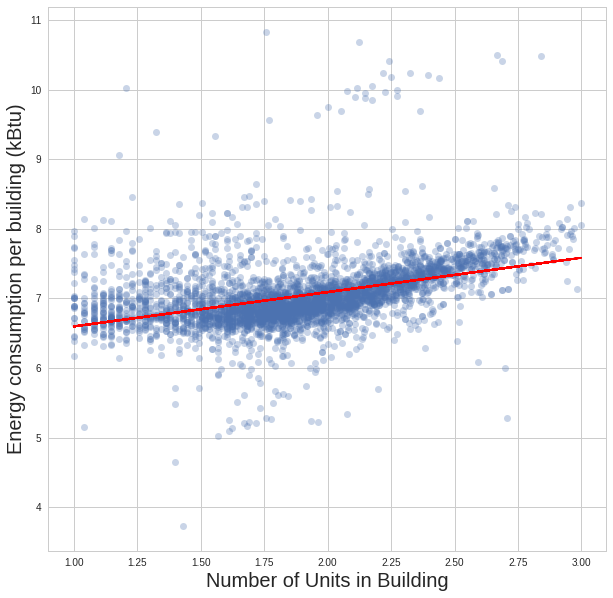

In [28]:
# plot here
fig2 = pl.figure(figsize=(10, 10))
ax2 = fig2.add_subplot(111)
ax2.plot(np.log10(df_cut.UnitsTotal), np.log10(df_cut.EnergyCons), 'o', alpha=0.3)
ax2.plot(np.log10(df_cut.UnitsTotal), lm2.predict(sm.add_constant(np.log10(df_cut.UnitsTotal))), 'r-')
ax2.set_xlabel("Number of Units in Building", fontsize=20)
ax2.set_ylabel("Energy consumption per building (kBtu)", fontsize=20);

## Chi-Square Test
The function is:

chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$

where the sum is over all datapoints,

for the i-th value model($x_i$) is the prediction, data($x_i$) the observation,

and $error_i$ is $\sqrt{data(x_i)}$

(but remember you worked in log space! What are the proper errors??

Assume Poisson statistics for the errors on the independent variable. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

In [29]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

### TODO: How to propagate errors to LOG!!!

In [30]:
# Chi-square for Units (DV) vs Energy (IV)
data = np.log10(df_cut.UnitsTotal)
model = lm1.predict(sm.add_constant(np.log10(df_cut.EnergyCons)))
error = np.sqrt(data)
errorLog = np.abs(error / df_cut.UnitsTotal / np.log(10))

print("{:.4f}".format(chi2(data, model, errorLog)))

72458390.0973


In [31]:
# Chi-square for Energy (DV) vs Units (IV)
data2 = np.log10(df_cut.EnergyCons) # endogenous / DV
model2 = lm2.predict(sm.add_constant(np.log10(df_cut.UnitsTotal)))
error2 = np.sqrt((df_cut.ReportedArea**2) + (df_cut.SiteEui**2))
errorLog2 = np.abs(error2 / df_cut.EnergyCons / np.log(10))

print("{:.4f}".format(chi2(data2, model2, errorLog2)))

3506018253907.0713


## Why Are We Using Reported Area and Site EUI for the error of Energy Consumption???
The reason why we get the sum of the squares of the Reported Area and the Site Energy Use Intensity is because the Energy Consumption was calculated by multiplying the two values. To account for both errors, we need to include the errors for both quantities.

propagation of errors on the log:https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

## Fit a 2nd degree polynomial

Dependent variable: Energy (y)

Independent variable: Units (x)

In [32]:
df2 = pd.DataFrame({'x': np.log10(df_cut.UnitsTotal), 'y': np.log10(df_cut.EnergyCons)})
df2['x2'] = df2.x**2
df2.head()

,x,y,x2
2,1.748188,7.616811,3.056161
16,1.380211,7.629287,1.904983
18,1.380211,7.286094,1.904983
19,1.792392,6.950549,3.212668
20,1.929419,6.811909,3.722657


In [33]:
x_fit = np.arange(np.log10(df_cut.UnitsTotal).min(), np.log10(df_cut.UnitsTotal).max(), 0.01)
poly_fit = pd.DataFrame({'x': x_fit, 'x2': x_fit**2})
len(poly_fit)

200

In [34]:
pm = smf.ols(formula='y ~ x2 + x', data=df2).fit()
pm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     598.9
Date:                Fri, 20 Oct 2017   Prob (F-statistic):          2.87e-228
Time:                        15:49:29   Log-Likelihood:                -2205.7
No. Observations:                4008   AIC:                             4417.
Df Residuals:                    4005   BIC:                             4436.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.1247      0.116     70.335      0.000         7.898     8.351
x2             0.5799      0.032     18.217      0.000         0.518     0.642
x             -1.7194      0.123    -14.023      0.000        -1.960    -1.479
==============================================================================
Omnibus:                     2374.005   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63876.741
Skew:                           2.328   Prob(JB):                         0.00
Kurtosis:                      21.995   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

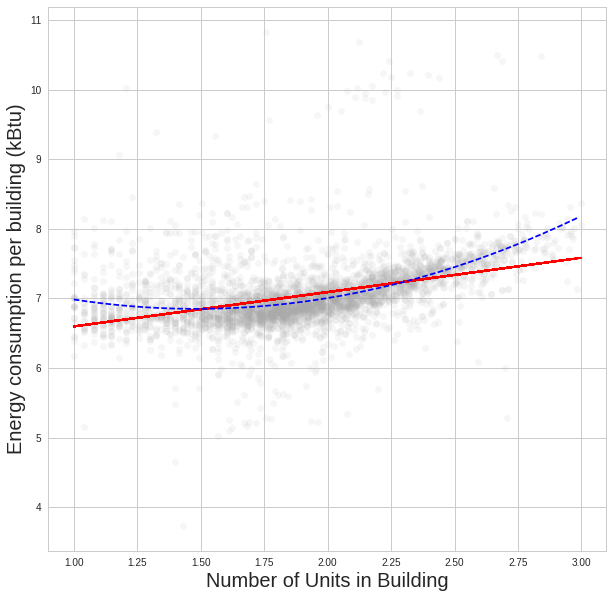

In [35]:
fig3 = pl.figure(figsize=(10, 10))
ax3 = fig3.add_subplot(111)
ax3.plot(np.log10(df_cut.UnitsTotal), np.log10(df_cut.EnergyCons), 'o', color='#aaaaaa', alpha=0.1)
ax3.plot(np.log10(df_cut.UnitsTotal), lm2.predict(sm.add_constant(np.log10(df_cut.UnitsTotal))), 'r-')
ax3.plot(x_fit, pm.predict(sm.add_constant(poly_fit)), 'b--')
ax3.set_xlabel("Number of Units in Building", fontsize=20)
ax3.set_ylabel("Energy consumption per building (kBtu)", fontsize=20);

## Likelihood Ratio Test

In [36]:
linemodel = lm2
curvemodel = pm

In [37]:
print ("LR : ", -2 * (-linemodel.llf - (-curvemodel.llf)))
print ("LR from statsmodels:", curvemodel.compare_lr_test(linemodel)[0])

LR :  -319.063300643
LR from statsmodels: 319.063300643


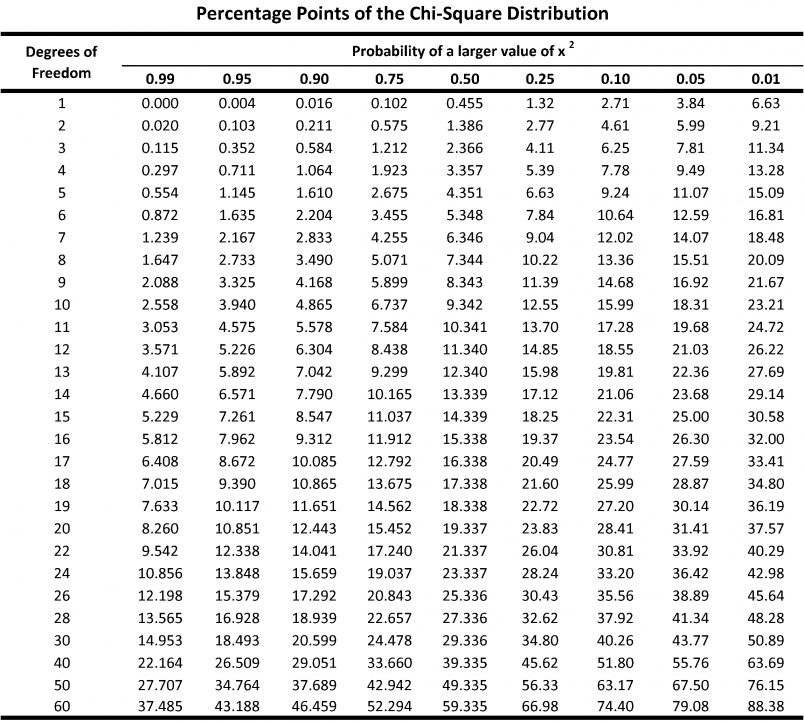

In [38]:
from IPython.display import Image
Image('http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG')

## EXPLAIN

# EXTRA CREDIT: Get creative with the data

In [39]:
# bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

# bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
#                 fontsize=22, colormap='gist_rainbow', alpha = 1, 
#                 marker='o',  figsize=(16, 14), loglog=True,  
#                 xlim=(1000,1e11), ylim=(1,1000), 
#                 c=bblnrgdata['YearBuilt']-1900, 
#                 s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
# pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
# pl.ylabel("total number of units", fontsize=22)
# pl.xlabel("total energy consumption (kBtu)", fontsize=22)